<a href="https://colab.research.google.com/github/chunlam-chan/quantum-coding-samples/blob/main/qaoa_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QAOA for MIMO Detection, Part 2: Comparision to RQAOA

Some literature has demonstrated that the standard QAOA at any constant circuit depth $p$ (a.k.a. level $p$) fails to solve certain optimization problems effectively. These problematic cases occur when the Hamiltonian encoding the problem is *local*, with interactions between the individual components limited to nearby neighbors, while interactions beyond a certain range are negligible. To address this limitation, a non-local variant of QAOA called recurisve QAOA (RQAOA) has been introduced in [[1]](#[1]).

Empirical evidence in [[1]](#[1]) and [[2]](#[2]) suggests that level-1 RQAOA can be a competitive algorithm for certain problems on regular graphs that can be described by a local Hamiltonian. Notably, [[1]](#[1]) provides an analytical proof of instances where RQAOA achieves a superior approximation ratio compared to QAOA.
Moreover, despite RQAOA not being initially motivated for non-local Hamiltonians, [[3]](#[3]) offers a further analytic proof that level-1 RQAOA outperforms level-1 QAOA in solving the MAX-CUT problem on complete graphs.

To explore if the result of [[3]](#[3]) can have a broader implication regarding the performance of RQAOA on complete graphs, this notebook compares the performance of QAOA and RQAOA for the problem of MIMO detection.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In [ ]:
try:
    import pennylane as qml
except ImportError as e:
    # Install pennylane if package is not already installed
    !pip install pennylane
    import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from matplotlib import pyplot as plt
from scipy.optimize import minimize, LinearConstraint

np.random.seed(2023)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 20.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


## Implementation of QAOA and RQAOA

First, we code the instance of the model and the QAOA solver for MIMO detection, following the steps outlined in the notebook for Part I.

In [ ]:
def gen_instance(M, N, scheme='simple'):
  if scheme == 'simple':
    H = np.array([[1.2416, -0.1741],[0.3323, -0.0804]])
    x = np.array([-1,1])
    z = np.array([-1.5130, 0.3212])
    y = H @ x + z
  elif scheme == 'random':
    H = np.random.rand(M, N)
    x = (-1) ** np.random.randint(2, size=N)
    n = np.random.rand(M) * 0.1
    y = H @ x + n

  return x, H, y

In [ ]:
def mimo_detection(H, y):
  _, N = H.shape
  A = 2 * H.T @ H
  b = -2 * y.T @ H
  obs = [qml.PauliZ(i) @ qml.PauliZ(j) for j in range(N) for i in range(j)]
  coeffs = [A[i,j].numpy() for j in range(N) for i in range(j)]
  obs = obs + [qml.PauliZ(i) for i in range(N)]
  coeffs = coeffs + list(b.numpy())
  cost_h = qml.Hamiltonian(coeffs, obs)
  mixer_h = qaoa.x_mixer(wires=range(N))
  return cost_h, mixer_h

In [ ]:
class QAOA:
  def __init__(self, cost_h, mixer_h, N, depth):
    self.cost_h = cost_h
    self.mixer_h = mixer_h
    self.depth = depth
    self.wires = range(N)
    self.dev = qml.device('default.qubit', wires=self.wires)

  def _qaoa_layer(self, gamma, alpha):
    qaoa.cost_layer(gamma, self.cost_h)
    qaoa.mixer_layer(alpha, self.mixer_h)

  def _circuit(self, params):
    for w in self.wires:
      qml.Hadamard(wires=w)
    qml.layer(self._qaoa_layer, self.depth, params[0], params[1])

  def cost_function(self, params):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit(params)
      return qml.expval(self.cost_h)

    return qnode()

  def probability_circuit(self, gamma, alpha):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit([gamma, alpha])
      return qml.probs(wires=self.wires)

    return qnode()

  def draw_circuit(self, gamma, alpha):
    @qml.qnode(self.dev)
    def qnode(gamma, alpha):
      self._circuit([gamma, alpha])
      return qml.probs(wires=self.wires)

    return qml.draw_mpl(qnode, decimals=1, expansion_strategy='device')

  def cost_function_for_scipy(self, params_flat):
    params = params_flat.reshape((2,-1))
    return self.cost_function(params)

In [ ]:
def qaoa_solver(H, y, depth):
  _, N = H.shape
  cost_h, mixer_h = mimo_detection(H, y)
  qaoa_mimo = QAOA(cost_h, mixer_h, N, depth)

  params_flat = np.random.randn(2 * depth, requires_grad=True)
  linear_constraint = LinearConstraint(A=np.eye(2*depth), lb=np.zeros(2*depth), ub=2*np.pi*np.ones(2*depth))
  out = minimize(qaoa_mimo.cost_function_for_scipy, x0=params_flat, method='COBYLA', constraints=linear_constraint, options={'maxiter':100})
  params_cobyla = out['x'].reshape(2, -1)

  probs_cobyla = qaoa_mimo.probability_circuit(params_cobyla[0], params_cobyla[1])
  est_x_idx = np.argmax(probs_cobyla)
  est_x = [(-1) ** int(b) for b in np.binary_repr(est_x_idx, N)]

  return np.array(est_x).numpy()

Now, let's explore RQAOA, an algorithm that incorporates QAOA as a subroutine.  RQAOA is designed to solve a problem with $N$ variables, where each variable $z_i$ belongs to the set $\{-1, 1\}$ and the problem is described by a Hamiltonian $H_N$. RQAOA is executed through recursively imposing constraints to the set of variables and reducing the Hamiltonian to a simpler form for fewer qubits. In this context, it is important to recall that $\sigma_Z^{(i)}$ represents the Pauli-Z operator applied to the $i$-th qubit. To summarize, the RQAOA algorithm can be outlined as follows:

1. Apply the QAOA to $H_N$ and prepare the optimal state $\ket{\psi(\beta^*, \gamma^*)}$ where $\beta^*, \gamma^*$ maximizes $\bra{\psi(\beta, \gamma)} H_N \ket{\psi(\beta, \gamma)}$.

2. Compute $M_{i,j} = \bra{\psi(\beta, \gamma)} \sigma_Z^{(i)} \sigma_Z^{(j)} \ket{\psi(\beta, \gamma)}$ for every edge $(i,j)$.

3. Let $(k,l) = \arg \max_{i,j} M_{i,j}$.
  1. Apply a hard constraint to the decision variables: $z_l = \text{sgn}(M_{k,l}) z_k$.
  2. Reduce $H_N$ to $H_{N-1}$ by replacing $\sigma_Z^{(l)}$ in $H_N$ with $\text{sgn}(M_{i,j}) \sigma_Z^{(k)}$.

4. Go back to Step 1 with $H = H_{N-1}$ unless the current $N$ is less than a pre-defined threshold $N_c$.

5. Solve the remaining problem classically.

For the MIMO detection with $x_{ML} = \min_{x \in \mathcal{X}^N} f(x)$ where
$$f(x) = \sum_{i<j} A_{i,j} x_i x_j + \sum_{i=1}^{N} b_i x_i,$$
let's see how we can adopt the RQAOA to the problem. Once we have chosen a pair $(k,l)$, in Step 3 we will set $x_l \rightarrow \alpha x_k$ with $\alpha = \pm 1$. We can then write
$$f(x) = \sum_{\substack{i<j \\ i,j \neq l}} A_{i,j} x_i x_j + \sum_{\substack{i=1 \\ i \neq l}}^{N} b_i x_i + \sum_{i<l} \alpha A_{il} x_i x_k + \sum_{l<j} \alpha A_{lj} x_k x_j + \alpha b_l x_k = \sum_{\substack{i<j \\ i,j \neq l}} A'_{i,j} x_i x_j + \sum_{\substack{i=1 \\ i \neq l}}^{N} b'_i x_i$$
where
$$A' =
\begin{cases}
A_{ij} \quad \text{if $i \neq k$ and $j \neq k$} \\
A_{ij} + \alpha A_{il} \quad \text{if $j=k$} \\
A_{ij} + \alpha A_{lj} \quad \text{if $i=k$} \\
\end{cases}$$
and
$$b' =
\begin{cases}
b_{i} \quad \text{if $i \neq k$} \\
b_{i} + \alpha b_{l} \quad \text{if $i=k$}.
\end{cases}$$
Therefore, the reduction from $H_N$ to $H_{N-1}$ in Step 3.2 is essentially by eliminating operators on index $l$ and working with $A'$ and $b'$ instead.

Here, we consider $N_c = 1$. Therefore, at the end of the recursion only one variable, say $x_i$, is left and $H_1 = b'_i \sigma_Z^{(i)}$. We can simply assign $x_i$ with $-\text{sgn}(b'_i)$. Because of the computation for different pairs $(i,j)$ in Step 2, the complexity of RQAOA is expanded by $O(N^2)$ compared to QAOA.

In [ ]:
class RQAOA(QAOA):
  def measure_correlation(self, params, pair):
    @qml.qnode(self.dev)
    def qnode():
      self._circuit(params)
      return qml.expval(qml.PauliZ(pair[0]) @ qml.PauliZ(pair[1]))

    return qnode()

In [ ]:
def rqaoa_solver(H, y, depth):
  _, N = H.shape
  candidates = [i for i in range(N)]
  N_can = len(candidates)
  relations = []

  A = 2 * H.T @ H
  b = -2 * y.T @ H

  while N_can > 1:
    # construct the Hamiltonian
    obs = [qml.PauliZ(i) @ qml.PauliZ(j) for j in range(N_can) for i in range(j)]
    coeffs = [A[candidates[i],candidates[j]].numpy() for j in range(N_can) for i in range(j)]
    obs = obs + [qml.PauliZ(i) for i in range(N_can)]
    coeffs = coeffs + [b[candidates[i]] for i in range(N_can)]
    cost_h = qml.Hamiltonian(coeffs, obs)
    mixer_h = qaoa.x_mixer(wires=range(N_can))

    # optimize the QAOA circuit
    rqaoa_mimo = RQAOA(cost_h, mixer_h, N_can, depth)
    params_flat = np.random.randn(2*depth, requires_grad=True)
    linear_constraint = LinearConstraint(A=np.eye(2*depth), lb=np.zeros(2*depth), ub=2*np.pi*np.ones(2*depth))
    out = minimize(rqaoa_mimo.cost_function_for_scipy, x0=params_flat, method='COBYLA', constraints=linear_constraint, options={'maxiter':100})
    params = out['x'].reshape(2,-1)

    # measure the correlations
    pair_list = []
    sign_list = []
    magnitude_list = []
    for j in range(N_can):
      for i in range(j):
        correlation = rqaoa_mimo.measure_correlation(params, [i, j])
        sign = np.sign(correlation)
        magnitude = np.abs(correlation)
        pair_list.append([candidates[i], candidates[j]])
        sign_list.append(sign)
        magnitude_list.append(magnitude)

    # prune a variable
    prune_idx = np.argmax(magnitude_list)
    prune_pair = pair_list[prune_idx]
    prune_sign = sign_list[prune_idx]
    relations.append([prune_pair[0], prune_pair[1], prune_sign])

    # update for the reduced problem
    candidates.remove(prune_pair[1])
    N_can -= 1
    A[prune_pair[0], prune_pair[0]] -= prune_sign * A[prune_pair[0], prune_pair[1]]
    A[:, prune_pair[0]] += prune_sign * A[:, prune_pair[1]]
    A[prune_pair[0], :] += prune_sign * A[prune_pair[1], :]
    b[prune_pair[0]] += prune_sign * b[prune_pair[1]]

  # Backtrack the solution
  est_x = np.zeros(N)
  est_x[candidates[0]] = - np.sign(b[candidates[0]])
  for i, j, sign in relations:
    est_x[j] = sign * est_x[i]

  return est_x.numpy()

## Experimental Results and Discussion

In the experiment below, we draw the channel matrix $H$ and the noise vector $n$ by i.i.d. Gaussian distribution, and draw $x$ uniformly. To compare QAOA with RQAOA, in addition to the success rate of returning the true $x$ perfectly, we also check the symbol error rate (SER), which is the fraction of incorrectedly decoded symbols. Let's see how they behave for a simple $3 \times 3$ system and various circuit depths.

In [ ]:
def qaoa_experiments(M, N, depth, trials):

  ser_qaoa_list = []
  ser_rqaoa_list = []
  success_qaoa = 0
  success_rqaoa = 0

  for t in range(trials):
    if t % 20 == 0:
      print(f'At trial {t}')

    x, H, y = gen_instance(M, N, scheme='random')

    est_x_qaoa = qaoa_solver(H, y, depth)
    est_x_rqaoa = rqaoa_solver(H, y, depth)

    ser_qaoa = 1 - np.sum(est_x_qaoa == x).numpy() / N
    ser_rqaoa = 1 - np.sum(est_x_rqaoa == x).numpy() / N

    ser_qaoa_list.append(ser_qaoa)
    ser_rqaoa_list.append(ser_rqaoa)

    success_qaoa += int(ser_qaoa == 0)
    success_rqaoa += int(ser_rqaoa == 0)

  success = [success_qaoa, success_rqaoa]
  ser_mean = [np.mean(ser_qaoa_list), np.mean(ser_rqaoa_list)]
  ser_std = [np.std(ser_qaoa_list), np.std(ser_rqaoa_list)]

  return success, ser_mean, ser_std


In [ ]:
M = 3
N = 3

depth_list = [1, 3, 8, 13]
trials = 100

success_list = []
ser_mean_list = []
ser_std_list = []

for depth in depth_list:
  print(f'==== At depth {depth} ====')
  success, ser_mean, ser_std = qaoa_experiments(M, N, depth, trials)
  success_list.append(success)
  ser_mean_list.append(ser_mean)
  ser_std_list.append(ser_std)


==== At depth 1 ====
At trial 0
At trial 20
At trial 40
At trial 60
At trial 80
==== At depth 3 ====
At trial 0
At trial 20
At trial 40
At trial 60
At trial 80
==== At depth 8 ====
At trial 0
At trial 20
At trial 40
At trial 60
At trial 80
==== At depth 13 ====
At trial 0
At trial 20
At trial 40
At trial 60
At trial 80


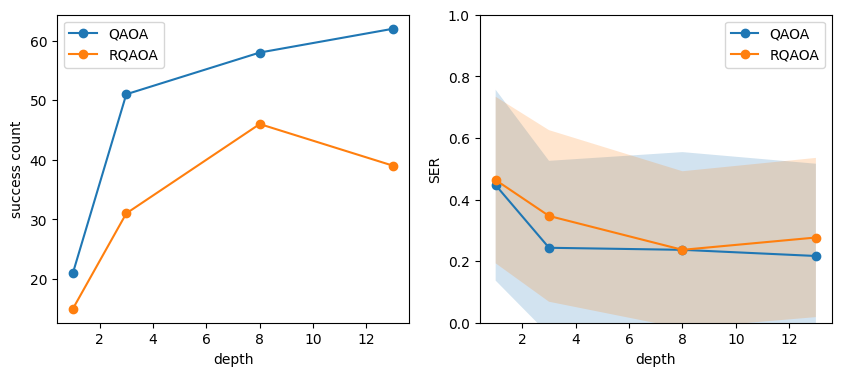

In [ ]:
success_array = np.array(success_list)
ser_mean_array = np.array(ser_mean_list)
ser_std_array = np.array(ser_std_list)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(depth_list, success_array[:, 0], '-o', label='QAOA')
ax[0].plot(depth_list, success_array[:, 1], '-o', label='RQAOA')
ax[0].legend()
ax[0].set_xlabel('depth')
ax[0].set_ylabel('success count')
ax[1].plot(depth_list, ser_mean_array[:, 0], '-o', label='QAOA')
ax[1].plot(depth_list, ser_mean_array[:, 1], '-o', label='RQAOA')
ax[1].fill_between(depth_list, ser_mean_array[:, 0] - ser_std_array[:, 0], ser_mean_array[:, 0] + ser_std_array[:, 0], alpha=0.2)
ax[1].fill_between(depth_list, ser_mean_array[:, 1] - ser_std_array[:, 1], ser_mean_array[:, 1] + ser_std_array[:, 1], alpha=0.2)
ax[1].legend()
ax[1].set_xlabel('depth')
ax[1].set_ylabel('SER')
ax[1].set_ylim([0,1])
plt.show()

The simulation results presented above indicate that, in the example cases examined, RQAOA does not outperform QAOA. The success rate achieved by RQAOA is significantly lower across different depths compared to QAOA. It is worth noting that the exceptionally low success rate observed for level-13 RQAOA might be attributed to the limited number of iterations allowed for the classical optimizer, chosen for computational efficiency purposes.

Despite the stark difference in the success rates, their SER are similar. Furthermore, the shaded regions in the right figure indicates a higher variance in SER achived by RQAOA. This suggests that while RQAOA may not be consistently successful in all cases, it can still provide close approximations, although on average, it is not as accurate as the estimate obtained by QAOA.

Finally, it is worth mentioning that [[4]](#[4]) provides interesting discussions on the factors that potentially hinder RQAOA from achieving perfect decoding; for example, optimal parameters for RQAOA might not be a good choice for leading us to the desired solution.

### References
<a id="references"></a>
<a id="[1]"></a>
1. S. Bravyi, A. Kliesch, R. Koenig, E. Tang, [*Obstacles to State Preparation and Variational Optimization from Symmetry Protection*](https://arxiv.org/abs/1910.08980), Phys. Rev. Lett. 125, 2020

<a id="[2]"></a>
2. S. Bravyi, A. Kliesch, R. Koenig, E. Tang, [*Hybrid quantum-classical algorithms for approximate graph coloring*](https://arxiv.org/abs/2011.13420), Quantum 6, 678, 2022

<!-- <a id="[3]"></a>
3. S. Bravyi, D. Gosset, D. Grier, L. Schaeffer, [*Classical algorithms for Forrelation*](https://arxiv.org/abs/2102.06963), arXiv:2102.06963, 2021 -->

<a id="[3]"></a>
3. E. Bae, S. Lee, [*Recursive QAOA outperforms the original QAOA for the MAX-CUT problem on complete graphs*](https://arxiv.org/abs/2211.15832), arXiv:2211.15832, 2023

<a id="[4]"></a>
4. Y. Patel, S. Jerbi, T. Bäck, V. Dunjko, [*Reinforcement Learning Assisted Recursive QAOA*](https://arxiv.org/abs/2207.06294), arXiv:2207.06294, 2022